# Question 5

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from ipynb.fs.full.funct import im2col

## Low Pass Filter :-
> Low pass filter using im2col and then applying column wise mean and reshaping it back

In [2]:
def lowPassFilt(im, k):
    r, c = im.shape
    x = int((k - 1)/2)
    x = max(x, 0)
    mat = np.zeros((r+k-1,c+k-1))
    mat[x:x+r, x:x+c] = im[:,:]
    out = im2col(mat, (k, k))
    out = np.mean(out, axis = 0)
    return out.reshape(r, c)

## Optimized Low pass filter :-
> Storing cumulative sum across all axis. Then for each pixel, removing cumulative sum till top of the kernel and till left of the kernel results in the desired value.

In [3]:
def lowPassFiltOptim(im, k):
    r, c = im.shape
    x = int((k - 1)/2)
    x = max(x, 0)
    mat = np.zeros((r+k-1,c+k-1))
    mat[x:x+r, x:x+c] = im[:,:]
    m1 = np.cumsum(mat, axis = 0)
    m2 = np.cumsum(m1, axis = 1)
    out = m2[k-1:r+k-1,k-1:c+k-1]+m2[0:r,0:c]-m2[k-1:r+k-1,0:c]-m2[0:r,k-1:c+k-1]+mat[k-1:r+k-1,0:c]+mat[0:r,k-1:c+k-1]
    return np.uint8(out/(k*k))

## Median Filter :-
> Basic median filter using numpy median and 2 for loops.

In [4]:
def median(img, k):
    out = np.uint8(np.zeros(img.shape))
    for i in range(k,img.shape[0]):
        for j in range(k,img.shape[1]):
            out[i, j] = np.median(img[i-k:i,j-k:j])
    return out

## Optimized Median Filter :-
> Optimized by keeping a histogram for kernel. Also stored column wise histogram for k rows and then for each column, subtracting the first column and adding the new,i.e., the current column.

In [5]:
def medianOpt(img, k):
    r, c = img.shape
    x = int((k - 1)/2)
    x = max(x, 0)
    mat = np.uint8(np.zeros((r+k-1,c+k-1)))
    mat[x:x+r, x:x+c] = img[:,:]
    rf, cf = mat.shape
    hist = np.zeros((256, cf))

    for i in range(k):
        hist[mat[i,:],np.arange(cf)] += 1

    out = np.zeros((r, c))
    
    for i in range(k-1, rf):
        kernel = np.sum(hist[:,0:k], axis = 1)
        for j in range(k-1, cf):
            x = np.cumsum(kernel)
            ind = np.searchsorted(x, (k*k)/2, side = 'left')
            out[i-k+1,j-k+1] = ind
            kernel += (hist[:,min(j+1,cf-1)] - hist[:,j-k+1])
        
        hist[mat[min(i+1,rf-1),:],np.arange(cf)] += 1
        hist[mat[i-k+1,:],np.arange(cf)] -= 1

    return out

In [6]:
def applyMed(im, k):
    if len(im.shape) < 3:
        return medianOpt(im, k)
    out = np.zeros(im.shape)
    for i in range(im.shape[2]):
        out[:,:,i] = medianOpt(im[:,:,i], k)
    return np.uint8(out)

## Comparing Low Pass Filters :-

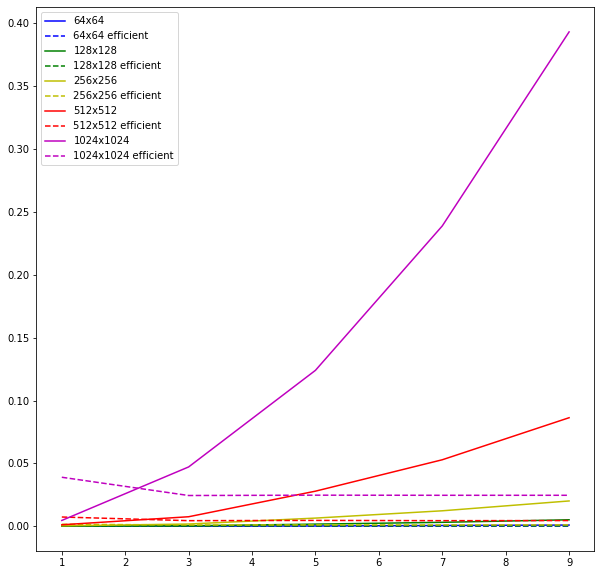

In [7]:
img = cv2.imread('./res/barbara.jpg')
img = np.int64(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))

k = [1, 3, 5, 7, 9]
sz = [64, 128, 256, 512, 1024]
plt.figure(figsize = (10,10))
color = ['b', 'g', 'y', 'r', 'm']
for i in range(len(sz)):
    tm1 = []
    tm2 = []
    im = img[0:sz[i],0:sz[i]]
    for j in k:
        st = time.time()
        out = lowPassFilt(im, j)
        tm1.append(time.time() - st)
        st = time.time()
        out = lowPassFiltOptim(im, j)
        tm2.append(time.time()-st)
    plt.plot(k,tm1, color = color[i], label = str(sz[i]) + 'x' + str(sz[i]))
    plt.plot(k,tm2, color = color[i], linestyle='dashed', label = str(sz[i]) + 'x' + str(sz[i]) + ' efficient')
plt.legend()    
plt.show()


## Comparing Median Filters :-

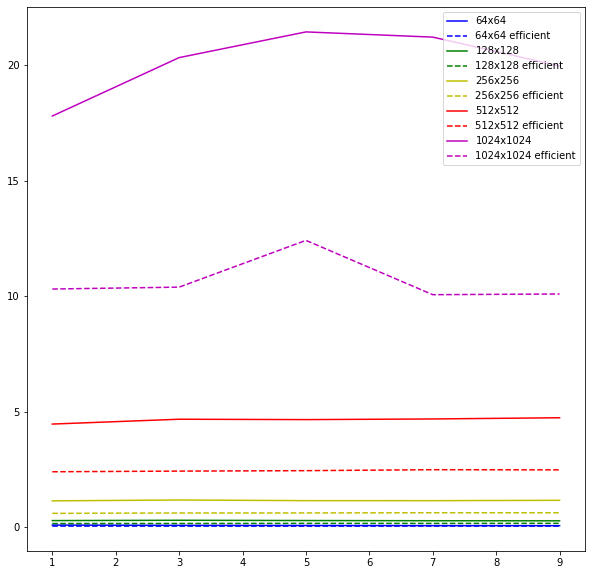

In [8]:
img = cv2.imread('./res/barbara.jpg')
img = np.int64(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))

k = [1, 3, 5, 7, 9]
sz = [64, 128, 256, 512, 1024]
plt.figure(figsize = (10,10))
color = ['b', 'g', 'y', 'r', 'm']
for i in range(len(sz)):
    tm1 = []
    tm2 = []
    im = img[0:sz[i],0:sz[i]]
    for j in k:
        st = time.time()
        out = median(im, j)
        tm1.append(time.time() - st)
        st = time.time()
        out = medianOpt(im, j)
        tm2.append(time.time()-st)
    plt.plot(k,tm1, color = color[i], label = str(sz[i]) + 'x' + str(sz[i]))
    plt.plot(k,tm2, color = color[i], linestyle='dashed', label = str(sz[i]) + 'x' + str(sz[i]) + ' efficient')
plt.legend()
plt.show()

## Result with mean filter

In [9]:
img = cv2.imread('./res/sui.jpg')
img = np.int64(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))

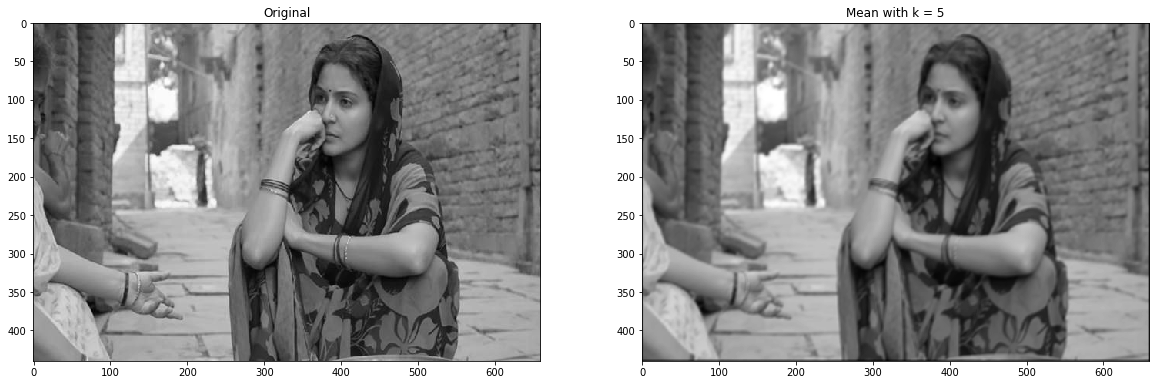

In [10]:
k = 5
out = lowPassFiltOptim(img, k)
arr = plt.subplots(1, 2, figsize =(20,20))[1]
arr[0].imshow(img, cmap = 'gray')
arr[0].set_title('Original')
arr[1].imshow(out, cmap = 'gray')
arr[1].set_title('Mean with k = ' + str(k))
plt.show()

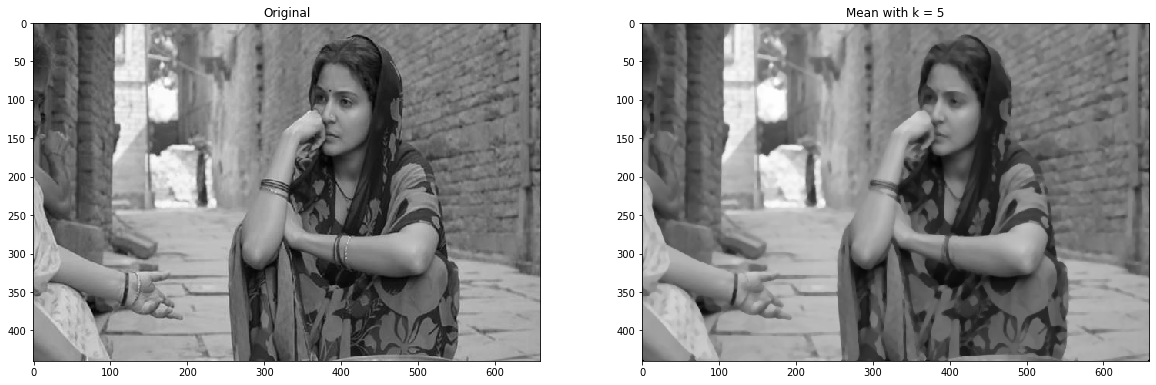

In [11]:
k = 5
out = applyMed(img, k)
arr = plt.subplots(1, 2, figsize =(20,20))[1]
arr[0].imshow(img, cmap = 'gray')
arr[0].set_title('Original')
arr[1].imshow(out, cmap = 'gray')
arr[1].set_title('Mean with k = ' + str(k))
plt.show()